In [73]:
import os
import pickle
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors, DataStructs
import ZMPY3D as zm
from pathlib import Path
from pyzernike import ZernikeDescriptor
import math
import matplotlib.pyplot as plt
import pandas as pd
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import seaborn as sns
from rdkit.Chem import rdMolAlign
import plotly.graph_objects as go
from tqdm import tqdm
from rdkit import DataStructs
from rdkit.Chem.Pharm2D import Generate, Gobbi_Pharm2D
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.feature_selection import mutual_info_regression
import scipy.stats as stats

In [74]:
sdf_file = '100_time_steps_generated_samples.sdf'

In [75]:
import pickle

MaxOrder=6

# Find the cache_data directory based on the site package location of ZMPY3D.
BinomialCacheFilePath=zm.__file__.replace('__init__.py', 'cache_data') + '/BinomialCache.pkl'
with open(BinomialCacheFilePath, 'rb') as file:
    BinomialCachePKL = pickle.load(file)

LogCacheFilePath=zm.__file__.replace('__init__.py', 'cache_data') + '/LogG_CLMCache_MaxOrder{:02d}.pkl'.format(MaxOrder)
with open(LogCacheFilePath, 'rb') as file:
    CachePKL = pickle.load(file)

BinomialCache=BinomialCachePKL['BinomialCache']

GCache_pqr_linear=CachePKL['GCache_pqr_linear']
GCache_complex=CachePKL['GCache_complex']
GCache_complex_index=CachePKL['GCache_complex_index']
CLMCache3D=CachePKL['CLMCache3D']
CLMCache=CachePKL['CLMCache']
RotationIndex=CachePKL['RotationIndex']

s_id=np.squeeze(RotationIndex['s_id'][0,0])-1
n   =np.squeeze(RotationIndex['n'][0,0])
l   =np.squeeze(RotationIndex['l'][0,0])
m   =np.squeeze(RotationIndex['m'][0,0])
mu  =np.squeeze(RotationIndex['mu'][0,0])
k   =np.squeeze(RotationIndex['k'][0,0])
IsNLM_Value=np.squeeze(RotationIndex['IsNLM_Value'][0,0])-1 

In [76]:
def OneTimeConversion(Voxel3D,Corner,GridWidth,BinomialCache, CLMCache, CLMCache3D, GCache_complex, GCache_complex_index, GCache_pqr_linear, MaxOrder, Param):
    
    Dimension_BBox_scaled=Voxel3D.shape

    XYZ_SampleStruct = {
        'X_sample': np.arange(Dimension_BBox_scaled[0] + 1),
        'Y_sample': np.arange(Dimension_BBox_scaled[1] + 1),
        'Z_sample': np.arange(Dimension_BBox_scaled[2] + 1)
    }

    # Calculate the volume mass and the center of mass
    [VolumeMass,Center,_]=zm.calculate_bbox_moment(Voxel3D,1,XYZ_SampleStruct)

    [AverageVoxelDist2Center,MaxVoxelDist2Center]=zm.calculate_molecular_radius(Voxel3D,Center,VolumeMass,Param['default_radius_multiplier'])

    Center_scaled=Center*GridWidth+Corner

    ##################################################################################
    # You may add any preprocessing on the voxel before applying the Zernike moment. #
    ##################################################################################

    # Calculate the weights for sphere sampling    
    SphereXYZ_SampleStruct=zm.get_bbox_moment_xyz_sample(Center,AverageVoxelDist2Center,Dimension_BBox_scaled)

    # Apply weights to the geometric moments
    _,_,SphereBBoxMoment=zm.calculate_bbox_moment(Voxel3D,MaxOrder,SphereXYZ_SampleStruct)

    # Convert to unscaled 3D Zernike moments
    [_, ZMoment_raw]=zm.calculate_bbox_moment_2_zm(MaxOrder, GCache_complex, GCache_pqr_linear, GCache_complex_index, CLMCache3D, SphereBBoxMoment)

    # Calculate alternative 3D Zernike moments for specific normalisation orders 2, 3, 4, 5 and 6
    ABList_2=zm.calculate_ab_rotation_all(ZMoment_raw, 2)
    ABList_3=zm.calculate_ab_rotation_all(ZMoment_raw, 3)
    ABList_4=zm.calculate_ab_rotation_all(ZMoment_raw, 4)
    ABList_5=zm.calculate_ab_rotation_all(ZMoment_raw, 5)
    ABList_6=zm.calculate_ab_rotation_all(ZMoment_raw, 6)

    ABList_all=np.vstack(ABList_2+ABList_3+ABList_4+ABList_5+ABList_6)

    ZMList_all=zm.calculate_zm_by_ab_rotation(ZMoment_raw, BinomialCache, ABList_all, MaxOrder, CLMCache,s_id,n,l,m,mu,k,IsNLM_Value)
    
    ZMList_all=np.stack(ZMList_all,axis=3)

    ZMList_all=np.transpose(ZMList_all,(2,1,0,3))
    ZMList_all=ZMList_all[~np.isnan(ZMList_all)]
    
    # Based on ABList_all, it is known in advance that Order 6 will definitely have 96 pairs of AB, which means 96 vectors.
    ZMList_all=np.reshape(ZMList_all,(np.int64(ZMList_all.size/96),96)) 

    return Center_scaled, ABList_all,ZMList_all


print(f"Merge all steps into a single callable function, OneTimeConversion, generating alternative 3D Zernike moments for rotational variations")
 

Merge all steps into a single callable function, OneTimeConversion, generating alternative 3D Zernike moments for rotational variations


In [77]:
Param = {
    'default_radius_multiplier': 1.6,
}

In [78]:
def get_molecule_params_and_coords2(mol):
    """
    Извлекает координаты и уникальные свойства атомов из объекта RDKit mol.
    """
    pt = Chem.GetPeriodicTable()
    
    # 1. Получаем координаты
    conf = mol.GetConformer()
    xyz = conf.GetPositions()
    
    # 2. Собираем данные об атомах
    atom_symbols = []
    unique_elements = set()
    
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        atom_symbols.append(symbol)
        unique_elements.add(symbol)
        
    # 3. Генерируем карты весов и радиусов только для присутствующих элементов
    # Коэффициент sqrt(5/3) взят из вашего исходного кода для белков #math.sqrt(5.0 / 3.0)
    
    radius_map = {}
    
    for symbol in unique_elements:
        # Ван-дер-Ваальсов радиус * ваш коэффициент
        radius_map[symbol] = pt.GetRvdw(symbol)
        
    return xyz, atom_symbols, radius_map

In [79]:
def create_hard_voxel_from_sdf(mol, grid_width=0.2):
    # 1. Загрузка и подготовка
    if mol.GetNumConformers() == 0:
        AllChem.EmbedMolecule(mol, AllChem.ETKDG())

    pt = Chem.GetPeriodicTable()
    conf = mol.GetConformer()
    xyz = conf.GetPositions()
    
    # Реальный физический центр масс (в Ангстремах)
    center_mass = np.mean(xyz, axis=0)
    # Центрируем координаты для вокселизации
    xyz_centered = xyz - center_mass
    
    # 2. Определение размеров куба
    max_dist = np.max(np.linalg.norm(xyz_centered, axis=1))
    cube_side_angstrom = (max_dist + 3.0) * 2
    cube_size = int(np.ceil(cube_side_angstrom / grid_width))
    
    voxel_cube = np.zeros((cube_size, cube_size, cube_size), dtype=np.float32)
    # Индекс центрального вокселя
    grid_center = cube_size // 2

    # --- ВОТ ТУТ СЧИТАЕМ CORNER ---
    # Это координата [0,0,0] вокселя в реальном пространстве SDF-файла
    corner_xyz = center_mass - (grid_center * grid_width)
    # ------------------------------

    # 3. Заполнение "шариков"
    for i, atom in enumerate(mol.GetAtoms()):
        symbol = atom.GetSymbol()
        weight = 1.0 # Либо pt.GetAtomicWeight(symbol)
        radius = pt.GetRvdw(symbol) * 0.8
        
        # Позиция центра атома в индексах сетки
        atom_grid_pos = np.round(xyz_centered[i] / grid_width).astype(int) + grid_center
        
        r_vox = int(np.ceil(radius / grid_width))
        z, y, x = np.ogrid[-r_vox : r_vox+1, -r_vox : r_vox+1, -r_vox : r_vox+1]
        dist_sq = (x**2 + y**2 + z**2) * (grid_width**2)
        mask = dist_sq <= (radius**2)
        
        # Границы вставки (защиту от выхода за края массива лучше оставить)
        z_s, z_e = atom_grid_pos[0]-r_vox, atom_grid_pos[0]+r_vox+1
        y_s, y_e = atom_grid_pos[1]-r_vox, atom_grid_pos[1]+r_vox+1
        x_s, x_e = atom_grid_pos[2]-r_vox, atom_grid_pos[2]+r_vox+1
        
        # Вставляем значения
        voxel_cube[z_s:z_e, y_s:y_e, x_s:x_e][mask] = weight

    return voxel_cube, corner_xyz

In [80]:
def load_molecules_from_sdf(filepath, max_molecules=None, removeHs=False, sanitize=True, start_from=0):
    
    molecules = []
    supplier = Chem.SDMolSupplier(filepath, removeHs=removeHs, sanitize=sanitize)
    mol: Chem.Mol

    print(f"Загрузка молекул из: {filepath}")
    print(f"Общее количество молекул в файле: {len(supplier)}")
    print(f"Начало загрузки с индекса: {start_from}")
    
    i = start_from
    max_molecules = max_molecules - start_from
    loaded_count = 0
    for i, mol in enumerate(supplier):
        if i < start_from:
            continue
        if max_molecules is not None and loaded_count >= max_molecules:
            break
            
        if mol is not None:
            molecules.append(mol)   
            loaded_count += 1
    
   
    
    return molecules

In [81]:
molecules = load_molecules_from_sdf(sdf_file, max_molecules=100, start_from=0)

Загрузка молекул из: 100_time_steps_generated_samples.sdf
Общее количество молекул в файле: 5045
Начало загрузки с индекса: 0


In [82]:
GridWidth = 1.0

results = [(get_molecule_params_and_coords2(mol),
            create_hard_voxel_from_sdf(mol))
           for mol in molecules]

xyz, all_atom_lists, radius_maps, voxelcubes, corners = zip(*[
    ((params[0], params[1], params[2], voxel[0], voxel[1]))
    for params, voxel in results
])

In [83]:

ZMList_All = []
for i in tqdm(range(len(molecules)), desc="Processing molecules", unit="mol"):
    _, _, zma_result = OneTimeConversion(voxelcubes[i], corners[i], GridWidth, BinomialCache, CLMCache, CLMCache3D, GCache_complex, GCache_complex_index, GCache_pqr_linear, MaxOrder, Param)
    ZMList_All.append(zma_result)

Processing molecules: 100%|██████████| 100/100 [00:05<00:00, 16.87mol/s]


In [84]:
def visualize_voxels_overlay(voxels_list, titles=None, colorscales=None, 
                            opacities=None, isomin_factor=0.3, isomax_factor=0.5):
    """
    Визуализация вокселей с наложением (для сравнения).
    
    Параметры:
    - voxels_list: список 3D numpy массивов
    - titles: список заголовков
    - colorscales: список цветовых схем
    - opacities: список значений прозрачности
    """
    if titles is None:
        titles = [f"Voxel {i+1}" for i in range(len(voxels_list))]
    
    if colorscales is None:
        colorscales = ['viridis', 'plasma', 'thermal', 'rainbow', 'portland'][:len(voxels_list)]
    
    if opacities is None:
        opacities = [0.35 + i * 0.1 for i in range(len(voxels_list))]
    
    fig = go.Figure()
    
    for idx, voxel in enumerate(voxels_list):
        # Создаем координатную сетку
        x, y, z = np.meshgrid(
            np.arange(voxel.shape[0]),
            np.arange(voxel.shape[1]),
            np.arange(voxel.shape[2]),
            indexing='ij'
        )
        
        # Преобразуем в 1D массивы
        x_flat = x.flatten()
        y_flat = y.flatten()
        z_flat = z.flatten()
        values_flat = voxel.flatten()
        
        # Добавляем изоповерхность
        fig.add_trace(go.Isosurface(
            x=x_flat,
            y=y_flat,
            z=z_flat,
            value=values_flat,
            isomin=voxel.mean() * isomin_factor,
            isomax=voxel.max() * isomax_factor,
            surface_count=2,
            opacity=opacities[idx],
            caps=dict(x_show=False, y_show=False, z_show=False),
            colorscale=colorscales[idx],
            name=titles[idx],
            showlegend=True
        ))
    
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectratio=dict(x=1.5, y=1.5, z=1.5)
        ),
        title="3D Voxel Comparison (Overlay)",
        legend_title="Molecules",
        width=1000,
        height=700
    )
    
    fig.show()

In [85]:
#visualize_voxels_overlay(voxel_lst)

---

In [86]:
def calculate_zernike_similarity(ZMList_A, ZMList_B):
    """
    Вычисляет максимальное нормализованное сходство между двумя наборами 
    дескрипторов моментов Цернике.
    
    ZMList: матрицы размера (количество_коэффициентов, количество_ротаций)
    """
    
    # 1. Вычисляем матрицу скалярных произведений (как в вашем коде)
    # Используем абсолютное значение, так как моменты комплексные
    M = np.abs(ZMList_A.conj().T @ ZMList_B)
    
    # 2. Находим индексы максимального совпадения
    idx_a, idx_b = np.unravel_index(np.argmax(M), M.shape)
    max_val = M[idx_a, idx_b]
    
    # 3. Вычисляем нормы векторов, которые дали этот максимум
    # Нам нужны конкретные столбцы (или строки), соответствующие индексам
    norm_a = np.linalg.norm(ZMList_A[:, idx_a])
    norm_b = np.linalg.norm(ZMList_B[:, idx_b])
    
    # 4. Финальный Similarity Score (Косинусное сходство)
    similarity_score = max_val / (norm_a * norm_b)
    
    return similarity_score, (idx_a, idx_b)

In [87]:
'''def compare_first_vector(matrix1, matrix2):
    """
    Сравнивает только первые векторы-дескрипторы (первый столбец) двух матриц.
    """
    vector1 = matrix1[:, 0]
    vector2 = matrix2[:, 0]
    
    dist = np.linalg.norm(vector1 - vector2)
    return dist'''

'def compare_first_vector(matrix1, matrix2):\n    """\n    Сравнивает только первые векторы-дескрипторы (первый столбец) двух матриц.\n    """\n    vector1 = matrix1[:, 0]\n    vector2 = matrix2[:, 0]\n\n    dist = np.linalg.norm(vector1 - vector2)\n    return dist'

In [88]:
molecules_3d = []
for i in range(len(molecules)):
    mol = Chem.AddHs(molecules[i], addCoords=True) 
    AllChem.UFFOptimizeMolecule(mol, maxIters=200)
    molecules_3d.append(mol)


In [89]:
def compare_rdkit_3d_euclidean(mol1, mol2):
    """
    Сравнение через USR дескрипторы (L2 дистанция).
    """
    # Генерируем 3D-дескрипторы
    fp1 = rdMolDescriptors.GetUSR(mol1)
    fp2 = rdMolDescriptors.GetUSR(mol2)
    
    # Считаем евклидово расстояние
    dist = np.linalg.norm(np.array(fp1) - np.array(fp2))
    return dist

In [90]:
from rdkit.Chem import rdShapeHelpers

def _ensure_3d(molecules):
    mol_list = []
    for mol in molecules: 
        m = Chem.Mol(mol)
        m = Chem.AddHs(m, addCoords=True)
        if m.GetNumConformers() == 0:
            raise ValueError("zero conformers")
        mol_list.append(m)
    return mol_list


def shape_tanimoto_3d(molecules):

    shape_score_list = []
    m_list = _ensure_3d(molecules)

    for i in range(len(m_list) - 1):

        m1 = Chem.Mol(m_list[i])
        m2 = Chem.Mol(m_list[i + 1])
        dist = rdShapeHelpers.ShapeTanimotoDist(m1, m2)

        shape_score_list.append(float(1 - dist))

    return shape_score_list


In [91]:
def atom_difference(m1, m2):
    return abs(m1.GetNumAtoms() - m2.GetNumAtoms())

In [96]:
from rdkit.Chem import rdShapeAlign
from rdkit.Chem import rdShapeHelpers
pair_ids = []
dist_zernike_list = []
dist_rdkit_eucl_list = []
dist_rdkit_tani_list = []
dist_ZerRd_list = []
atom_diff_list=[]
m_list = _ensure_3d(molecules)

for i in range(len(molecules)):
    for j in range(i + 1, len(molecules)):
        pair_id = f"{i}_{j}"
        pair_ids.append(pair_id)



        atom_diff = atom_difference(molecules[i], molecules[j])
        atom_diff_list.append(atom_diff)

        # 1. Zernike
        d_z, _ = calculate_zernike_similarity(ZMList_All[i], ZMList_All[j])
        dist_zernike_list.append(1 - d_z)

        # 2. RDKit USR
        d_e = compare_rdkit_3d_euclidean(molecules[i], molecules[j])
        dist_rdkit_eucl_list.append(d_e)

        # 3. Shape Tanimoto
        m1 = Chem.Mol(m_list[i])
        m2 = Chem.Mol(m_list[j])
        rdShapeAlign.AlignMol(m2, m1)
        dist = rdShapeHelpers.ShapeTanimotoDist(m1, m2)
        dist_rdkit_tani_list.append(1.0 - dist)

        d_mean = d_z + d_e*0.1
        dist_ZerRd_list.append(d_mean)

df_results = pd.DataFrame({
    'id': pair_ids,
    'zernike': dist_zernike_list,
    'rdkit': dist_rdkit_eucl_list,
    'tanimoto': dist_rdkit_tani_list,
    'atom_diff': atom_diff_list
})

# Вывод первых строк для проверки
print(df_results.head())


    id   zernike     rdkit  tanimoto  atom_diff
0  0_1  0.041517  1.910396  0.448974          2
1  0_2  0.066281  1.597758  0.495559          2
2  0_3  0.239363  2.009344  0.457488          0
3  0_4  0.092331  1.258098  0.500760          3
4  0_5  0.054832  1.527234  0.538376          0


In [97]:
# Создаем DataFrame из ваших списков
data = {
    'Zernike_Dist': dist_zernike_list,
    'RDKit_USR_Dist': dist_rdkit_eucl_list,
    'RDKit_Tanimoto_Sim': dist_rdkit_tani_list
}

df = pd.DataFrame(data)

spearman_corr = df.corr(method='spearman')

print("\nSpearman corelation:")
print(spearman_corr)


Spearman corelation:
                    Zernike_Dist  RDKit_USR_Dist  RDKit_Tanimoto_Sim
Zernike_Dist            1.000000        0.517210           -0.429588
RDKit_USR_Dist          0.517210        1.000000           -0.797592
RDKit_Tanimoto_Sim     -0.429588       -0.797592            1.000000


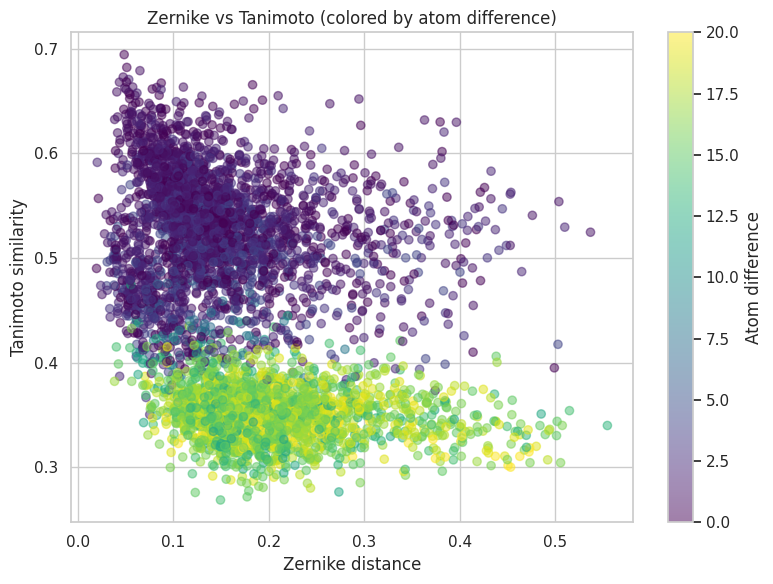

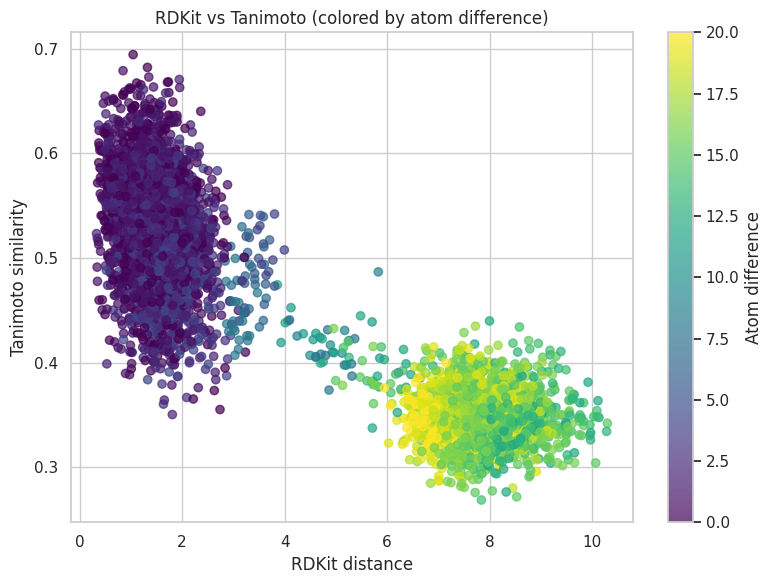

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

scatter = plt.scatter(
    df_results['zernike'],
    df_results['tanimoto'],
    c=df_results['atom_diff'],
    cmap='viridis',
    alpha=0.5
)

plt.xlabel('Zernike distance')
plt.ylabel('Tanimoto similarity')
plt.title('Zernike vs Tanimoto (colored by atom difference)')

cbar = plt.colorbar(scatter)
cbar.set_label('Atom difference')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))

scatter = plt.scatter(
    df_results['rdkit'],
    df_results['tanimoto'],
    c=df_results['atom_diff'],
    cmap='viridis',
    alpha=0.7
)

plt.xlabel('RDKit distance')
plt.ylabel('Tanimoto similarity')
plt.title('RDKit vs Tanimoto (colored by atom difference)')

cbar = plt.colorbar(scatter)
cbar.set_label('Atom difference')

plt.tight_layout()
plt.show()


In [95]:
# 1. Расчет дополнительных коэффициентов
def calculate_advanced_stats(df):
    results = []
    pairs = [('Zernike_Dist', 'RDKit_USR_Dist'), 
             ('Zernike_Dist', 'RDKit_Tanimoto_Sim'),
             ('RDKit_USR_Dist', 'RDKit_Tanimoto_Sim')]
    
    for c1, c2 in pairs:
        # Spearman
        rho, s_p = spearmanr(df[c1], df[c2])
        
        
        results.append({
            'Pair': f"{c1} vs {c2}",
            'Spearman_Rho': rho,
            
        })
    
    return pd.DataFrame(results)

advanced_df = calculate_advanced_stats(df)
print(advanced_df)


                                   Pair  Spearman_Rho
0        Zernike_Dist vs RDKit_USR_Dist     -0.517210
1    Zernike_Dist vs RDKit_Tanimoto_Sim      0.429588
2  RDKit_USR_Dist vs RDKit_Tanimoto_Sim     -0.797592
